Load and preprocess the datasets (MNIST, Fashion MNIST, and CIFAR-10):
python


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data(dataset_name):
    if dataset_name == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset_name == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset_name == 'cifar10':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    else:
        raise ValueError("Invalid dataset name. Choose from 'mnist', 'fashion_mnist', or 'cifar10'.")

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    if len(x_train.shape) < 4:  # If the dataset is grayscale, convert to RGB
        x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
        x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

    return x_train, y_train, x_test, y_test

dataset_name = "fashion_mnist"  
x_train, y_train, x_test, y_test = load_and_preprocess_data(dataset_name)


4422102/4422102 [==============================] - 1s 0us/step


a) Use simple neural network as well as LeNet-5 - two architectures:

In [ ]:
def simple_nn(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def lenet_5(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = x_train.shape[1:]
num_classes = 10

for model_architecture in [simple_nn, lenet_5]:
    model = model_architecture(input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
    model_score = model.evaluate(x_test, y_test)
    print(f"{model_architecture.__name__} Test Loss:", model_score[0])
    print(f"{model_architecture.__name__} Test Accuracy:", model_score[1])


Epoch 1/10
375/375 [==============================] - 8s 5ms/step - loss: 0.5374 - accuracy: 0.8126 - val_loss: 0.4988 - val_accuracy: 0.8227
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4132 - accuracy: 0.8541 - val_loss: 0.4152 - val_accuracy: 0.8497
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3668 - accuracy: 0.8673 - val_loss: 0.3778 - val_accuracy: 0.8643
Epoch 4/10
375/375 [==============================] - 1s 4ms/step - loss: 0.3384 - accuracy: 0.8790 - val_loss: 0.3562 - val_accuracy: 0.8736
Epoch 5/10
375/375 [==============================] - 1s 4ms/step - loss: 0.3186 - accuracy: 0.8837 - val_loss: 0.3534 - val_accuracy: 0.8748
Epoch 6/10
375/375 [==============================] - 1s 4ms/step - loss: 0.3047 - accuracy: 0.8883 - val_loss: 0.3316 - val_accuracy: 0.8794
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 0.2893 - accuracy: 0.8932 - val_loss: 0.3783 - val_accuracy: 0.8637
Epoch 

In [ ]:
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 17.4 MB/s eta 0:00:00


b) Demonstrate pretrained model with transfer learning (both EfficientNet and BiT):



In [ ]:
# 1. Install necessary libraries
!pip install -U tensorflow
!pip install tensorflow_hub

# 2. Import libraries
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# 3. Load and preprocess the fashion_mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

def preprocess_data(images, labels):
    images = images.astype("float32") / 255.0
    images = np.expand_dims(images, axis=-1)  # Add an extra dimension for grayscale channel
    images = tf.image.resize(images, (32, 32))  # Resize the images
    labels = tf.keras.utils.to_categorical(labels, 10)
    images = tf.image.grayscale_to_rgb(images)  # Convert grayscale to RGB
    return images, labels



x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# 4. Load pre-trained models (EfficientNet and BiT)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
bit_url = "https://tfhub.dev/google/bit/m-r50x1/1"

def create_model(model_url, input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        hub.KerasLayer(model_url, trainable=True),
        Dense(num_classes, activation='softmax')
    ])
    return model

efficientnet_model = create_model(efficientnet_url, (32, 32, 3), 10)
bit_model = create_model(bit_url, (32, 32, 3), 10)

# 5. Fine-tune the models
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

bit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training EfficientNet...")
efficientnet_history = efficientnet_model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.1)

print("\nTraining BiT...")
bit_history = bit_model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.1)

# 6. Evaluate the models
efficientnet_score = efficientnet_model.evaluate(x_test, y_test, verbose=0)
print("\nEfficientNet Test loss:", efficientnet_score[0])
print("EfficientNet Test accuracy:", efficientnet_score[1])

bit_score = bit_model.evaluate(x_test, y_test, verbose=0)
print("\nBiT Test loss:", bit_score[0])
print("BiT Test accuracy:", bit_score[1])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.2.1 requires jax>=0.4.8, but you have jax 0.3.25 which is incompatible.
flax 0.6.9 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
4422102/4422102 [==============================] - 0s 0us/step
Training EfficientNet...
Epoch 1/2
844/844 [==============================] - 683s 

c) Demonstrate image augmentation:

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

model = models.Sequential([
    layers.InputLayer(input_shape=(28, 28, 1)),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen.fit(x_train.reshape(-1, 28, 28, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model.fit(datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, batch_size=32), epochs=1, validation_data=(x_test.reshape(-1, 28, 28, 1), y_test))


1875/1875 [==============================] - 83s 43ms/step - loss: 0.6484 - accuracy: 0.7606 - val_loss: 0.4526 - val_accuracy: 0.8336


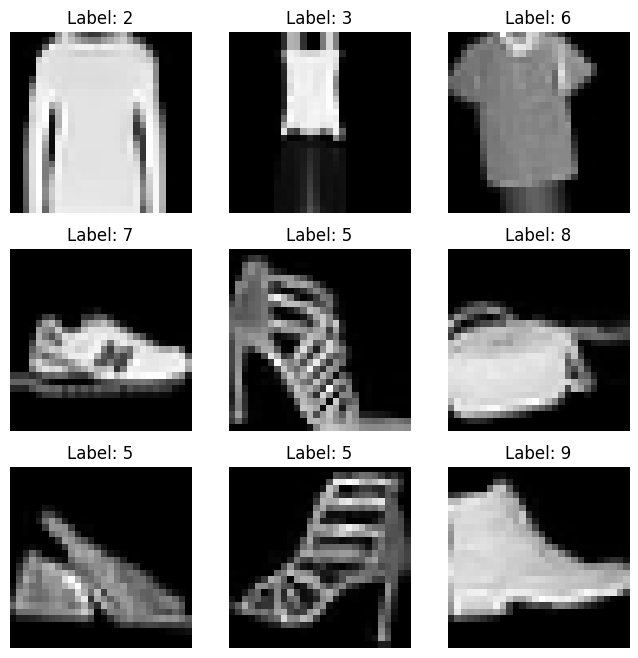

In [ ]:
import matplotlib.pyplot as plt

# Generate some augmented images
augmented_images = datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, batch_size=1)

# Display the first 9 augmented images
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.ravel()
for i in range(9):
    image, label = augmented_images.next()
    axs[i].imshow(image[0], cmap=plt.cm.gray)
    axs[i].set_title(f"Label: {label.argmax()}")
    axs[i].axis('off')

plt.show()


d) demonstrate with state of art image models - mlp-mixer

In [ ]:
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# 1. Install necessary libraries
!pip install tensorflow-addons
!pip install -U tensorflow

# 2. Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# 3. Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# 4. Implement the MLP-Mixer model
def mlp_block(units, dropout_rate=0.1):
    return keras.Sequential([
        layers.Dense(units, activation=tf.nn.gelu),
        layers.Dropout(dropout_rate),
    ])

def mixer_block(hidden_dim, num_patches, dropout_rate=0.1):
    return keras.Sequential([
        layers.LayerNormalization(),
        layers.Dense(num_patches, use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.Dropout(dropout_rate),
        layers.LayerNormalization(),
        layers.Dense(hidden_dim, use_bias=False),
        layers.Dropout(dropout_rate),
    ])

def mlp_mixer(input_shape, hidden_dim, num_blocks, num_patches, dropout_rate=0.1):
    inputs = keras.Input(shape=input_shape)
    x = layers.Reshape((-1, input_shape[-1]))(inputs)
    
    for _ in range(num_blocks):
        x = layers.Add()([x, mlp_block(hidden_dim)(mixer_block(hidden_dim, num_patches)(x))])

    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    return keras.Model(inputs=inputs, outputs=outputs)

# 5. Train the model
input_shape = (28, 28, 1)
hidden_dim = 64
num_blocks = 8
num_patches = 16

model = mlp_mixer(input_shape, hidden_dim, num_blocks, num_patches)
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=256, epochs=1, validation_split=0.1)

# 6. Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


211/211 [==============================] - 2805s 13s/step - loss: 2.3132 - accuracy: 0.1036 - val_loss: 2.3806 - val_accuracy: 0.0952
Test loss: 2.379917860031128
Test accuracy: 0.0957999974489212
